GitHub repository link: https://github.com/Prabhsimran18/Algerian-Forest-Fires/tree/main

## Importing Libraries


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# Changed import from LinearRegression to LogisticRegression
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


## Loading and Exploring Data


In [ ]:
try:
  df = pd.read_csv(r"C:\Users\Prabh\Downloads\Algerian_forest_fires_cleaned.csv")
except FileNotFoundError:
  print("Error: File not found. Please check the file path.")
  exit()


In [3]:

df.head()


,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  
 4   RH           243 non-null    int64  
 5   Ws           243 non-null    int64  
 6   Rain         243 non-null    float64
 7   FFMC         243 non-null    float64
 8   DMC          243 non-null    float64
 9   DC           243 non-null    float64
 10  ISI          243 non-null    float64
 11  BUI          243 non-null    float64
 12  FWI          243 non-null    float64
 13  Classes      243 non-null    object 
 14  Region       243 non-null    int64  
dtypes: float64(7), int64(7), object(1)
memory usage: 28.6+ KB


## Data Preprocessing


In [5]:
def clean_and_transform_data(df):
  # Check for missing values
  missing_values = df.isnull().sum()
  if missing_values.sum() > 0:
    imputer = SimpleImputer(strategy='median')
    df_processed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
  else:
    df_processed = df.copy()

  # Check for duplicate rows
  duplicate_rows = df_processed.duplicated().sum()
  if duplicate_rows > 0:
    df_processed = df_processed.drop_duplicates()

  # Convert 'Classes' to numerical values
  df_processed['Classes'] = df_processed['Classes'].str.strip().map({'fire': 1, 'not fire': 0})

  # Create a datetime column
  df_processed['date'] = pd.to_datetime(df_processed[['year', 'month', 'day']])

  return df_processed

df_cleaned = clean_and_transform_data(df)

## Data Filtering


Date : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012) Weather data observations       
Temp : temperature noon (temperature max) in Celsius degrees: 22 to 42      
RH : Relative Humidity in %: 21 to 90       
Ws :Wind speed in km/h: 6 to 29     
Rain: total day in mm: 0 to 16.8 FWI Components     
Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5      
Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9     
Drought Code (DC) index from the FWI system: 7 to 220.4     
Initial Spread Index (ISI) index from the FWI system: 0 to 18.5     
Buildup Index (BUI) index from the FWI system: 1.1 to 68        
Fire Weather Index (FWI) Index: 0 to 31.1       
Classes: two classes, namely Fire and not Fire      

We have data from two different regions : Bejaia Region and Sidi-Bel Abbes Region

In [6]:
def apply_data_filters(df):
  # Apply filters based on guidelines
  filtered_df = df[
    (df['Temperature'].between(22, 42)) &
    (df['RH'].between(21, 90)) &
    (df['Ws'].between(6, 29)) &
    (df['Rain'].between(0, 16.8)) &
    (df['FFMC'].between(28.6, 92.5)) &
    (df['DMC'].between(1.1, 65.9)) &
    (df['DC'].between(7, 220.4)) &
    (df['ISI'].between(0, 18.5)) &
    (df['BUI'].between(1.1, 68)) &
    (df['FWI'].between(0, 31.1))
  ]
  return filtered_df

df_filtered = apply_data_filters(df_cleaned)

## Exploratory Data Analysis


In [7]:
df_filtered.describe()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region,date
count,229.000000,229.000000,229.0,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229
mean,16.152838,7.467249,2012.0,32.030568,62.973799,15.532751,0.750655,77.901310,14.503057,49.968559,4.322707,16.625764,6.563755,0.554585,0.480349,2012-07-30 21:29:04.978166016
min,1.000000,6.000000,2012.0,22.000000,33.000000,6.000000,0.000000,36.100000,1.100000,7.000000,0.000000,1.600000,0.000000,0.000000,0.000000,2012-06-01 00:00:00
25%,9.000000,6.000000,2012.0,30.000000,54.000000,14.000000,0.000000,72.300000,5.800000,14.200000,1.400000,6.000000,0.700000,0.000000,0.000000,2012-06-30 00:00:00
50%,16.000000,7.000000,2012.0,32.000000,64.000000,15.000000,0.000000,82.700000,11.200000,33.100000,3.300000,11.900000,4.100000,1.000000,0.000000,2012-07-29 00:00:00
75%,24.000000,8.000000,2012.0,35.000000,73.000000,17.000000,0.500000,87.800000,19.400000,71.000000,6.900000,22.300000,10.600000,1.000000,1.000000,2012-08-31 00:00:00
max,31.000000,9.000000,2012.0,40.000000,90.000000,29.000000,16.800000,92.500000,65.900000,220.400000,14.300000,68.000000,31.100000,1.000000,1.000000,2012-09-30 00:00:00
std,8.801827,1.121959,0.0,3.351346,13.387255,2.840037,1.958934,13.247851,12.355173,48.588485,3.445326,14.325272,6.958867,0.498100,0.500708,NaN


In [8]:

# Visualizations
numerical_cols = df_filtered.drop(['day', 'month', 'year', 'date', 'Region', 'Classes'], axis=1).columns


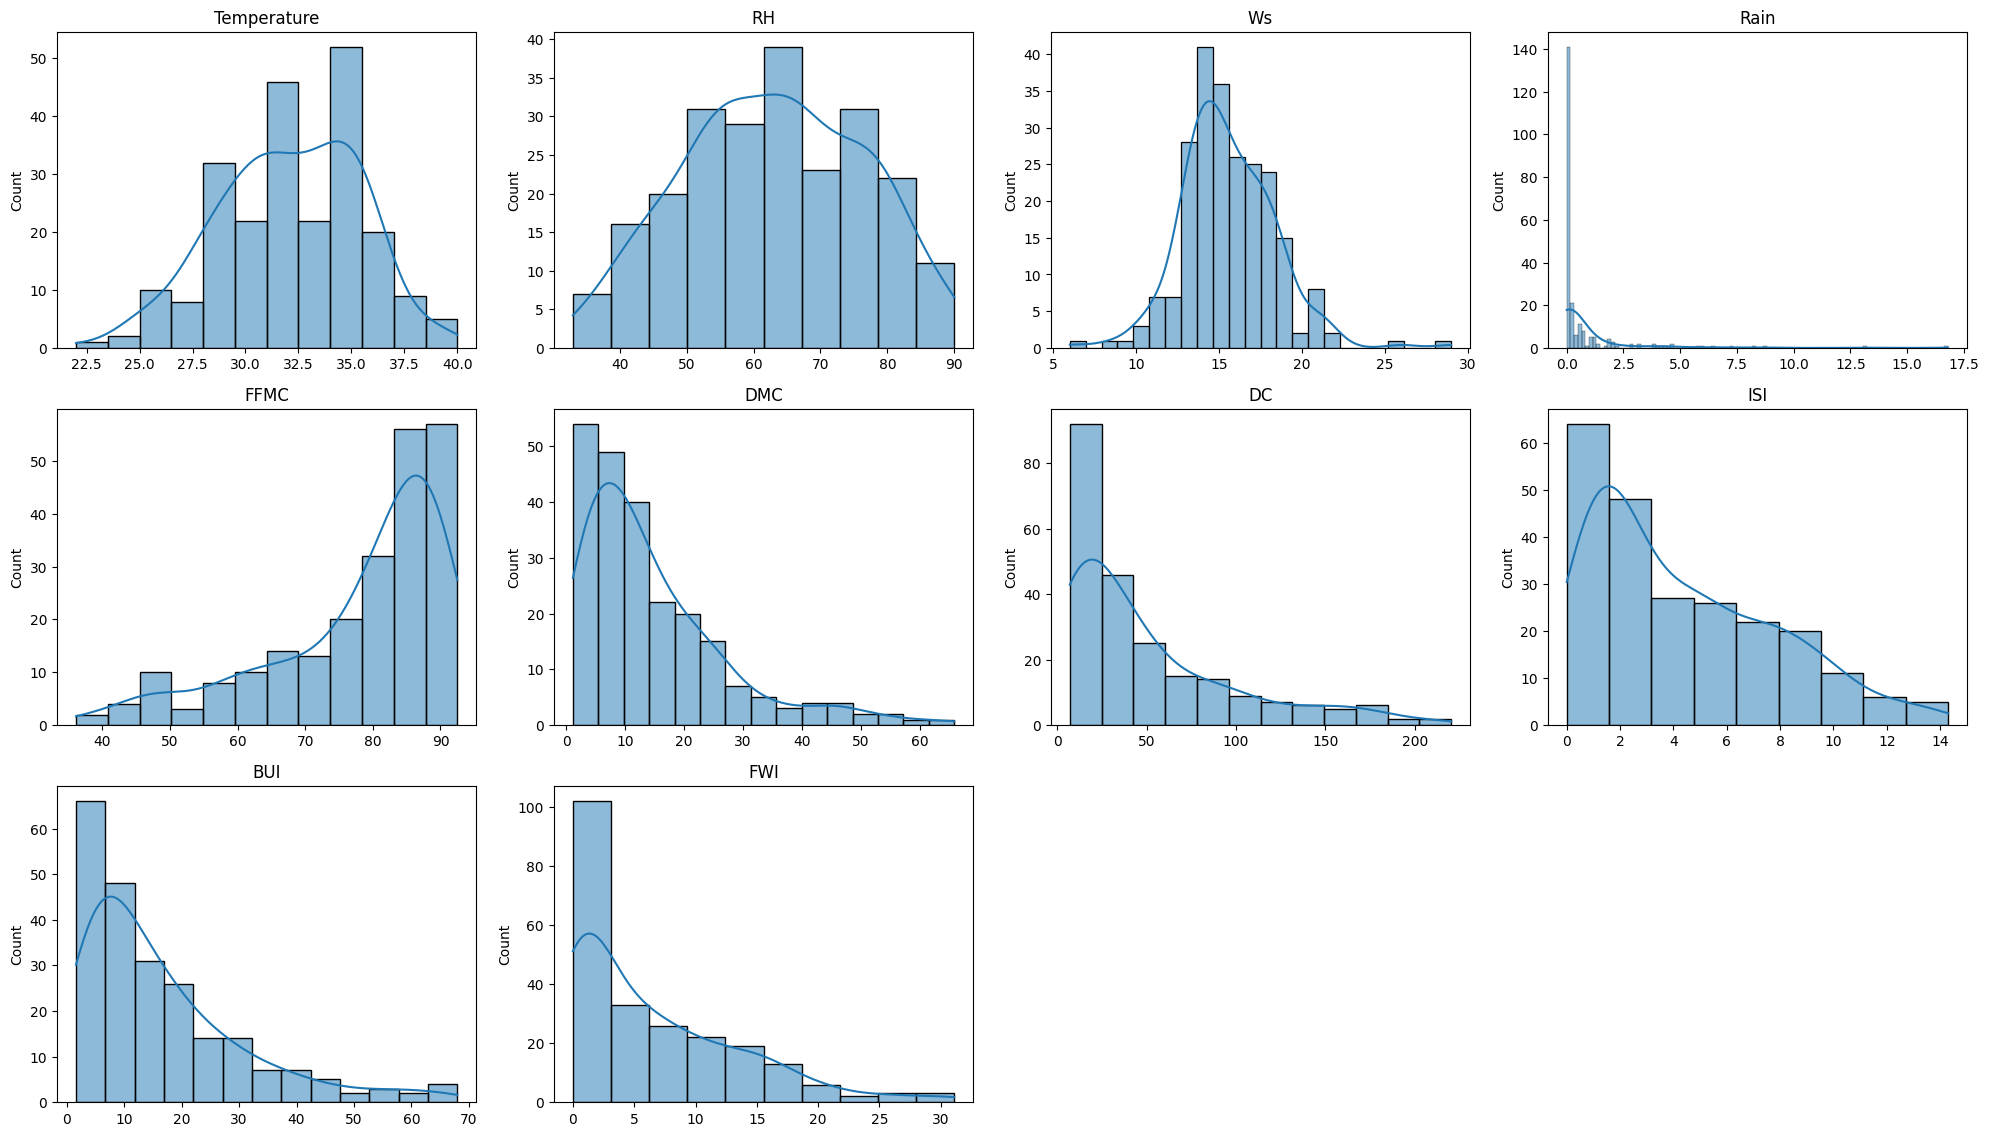

In [9]:

# Histograms
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols, 1):
  plt.subplot(4, 4, i)
  sns.histplot(df_filtered[col], kde=True)
  plt.title(col)
  plt.xlabel('')
plt.tight_layout()
plt.show()



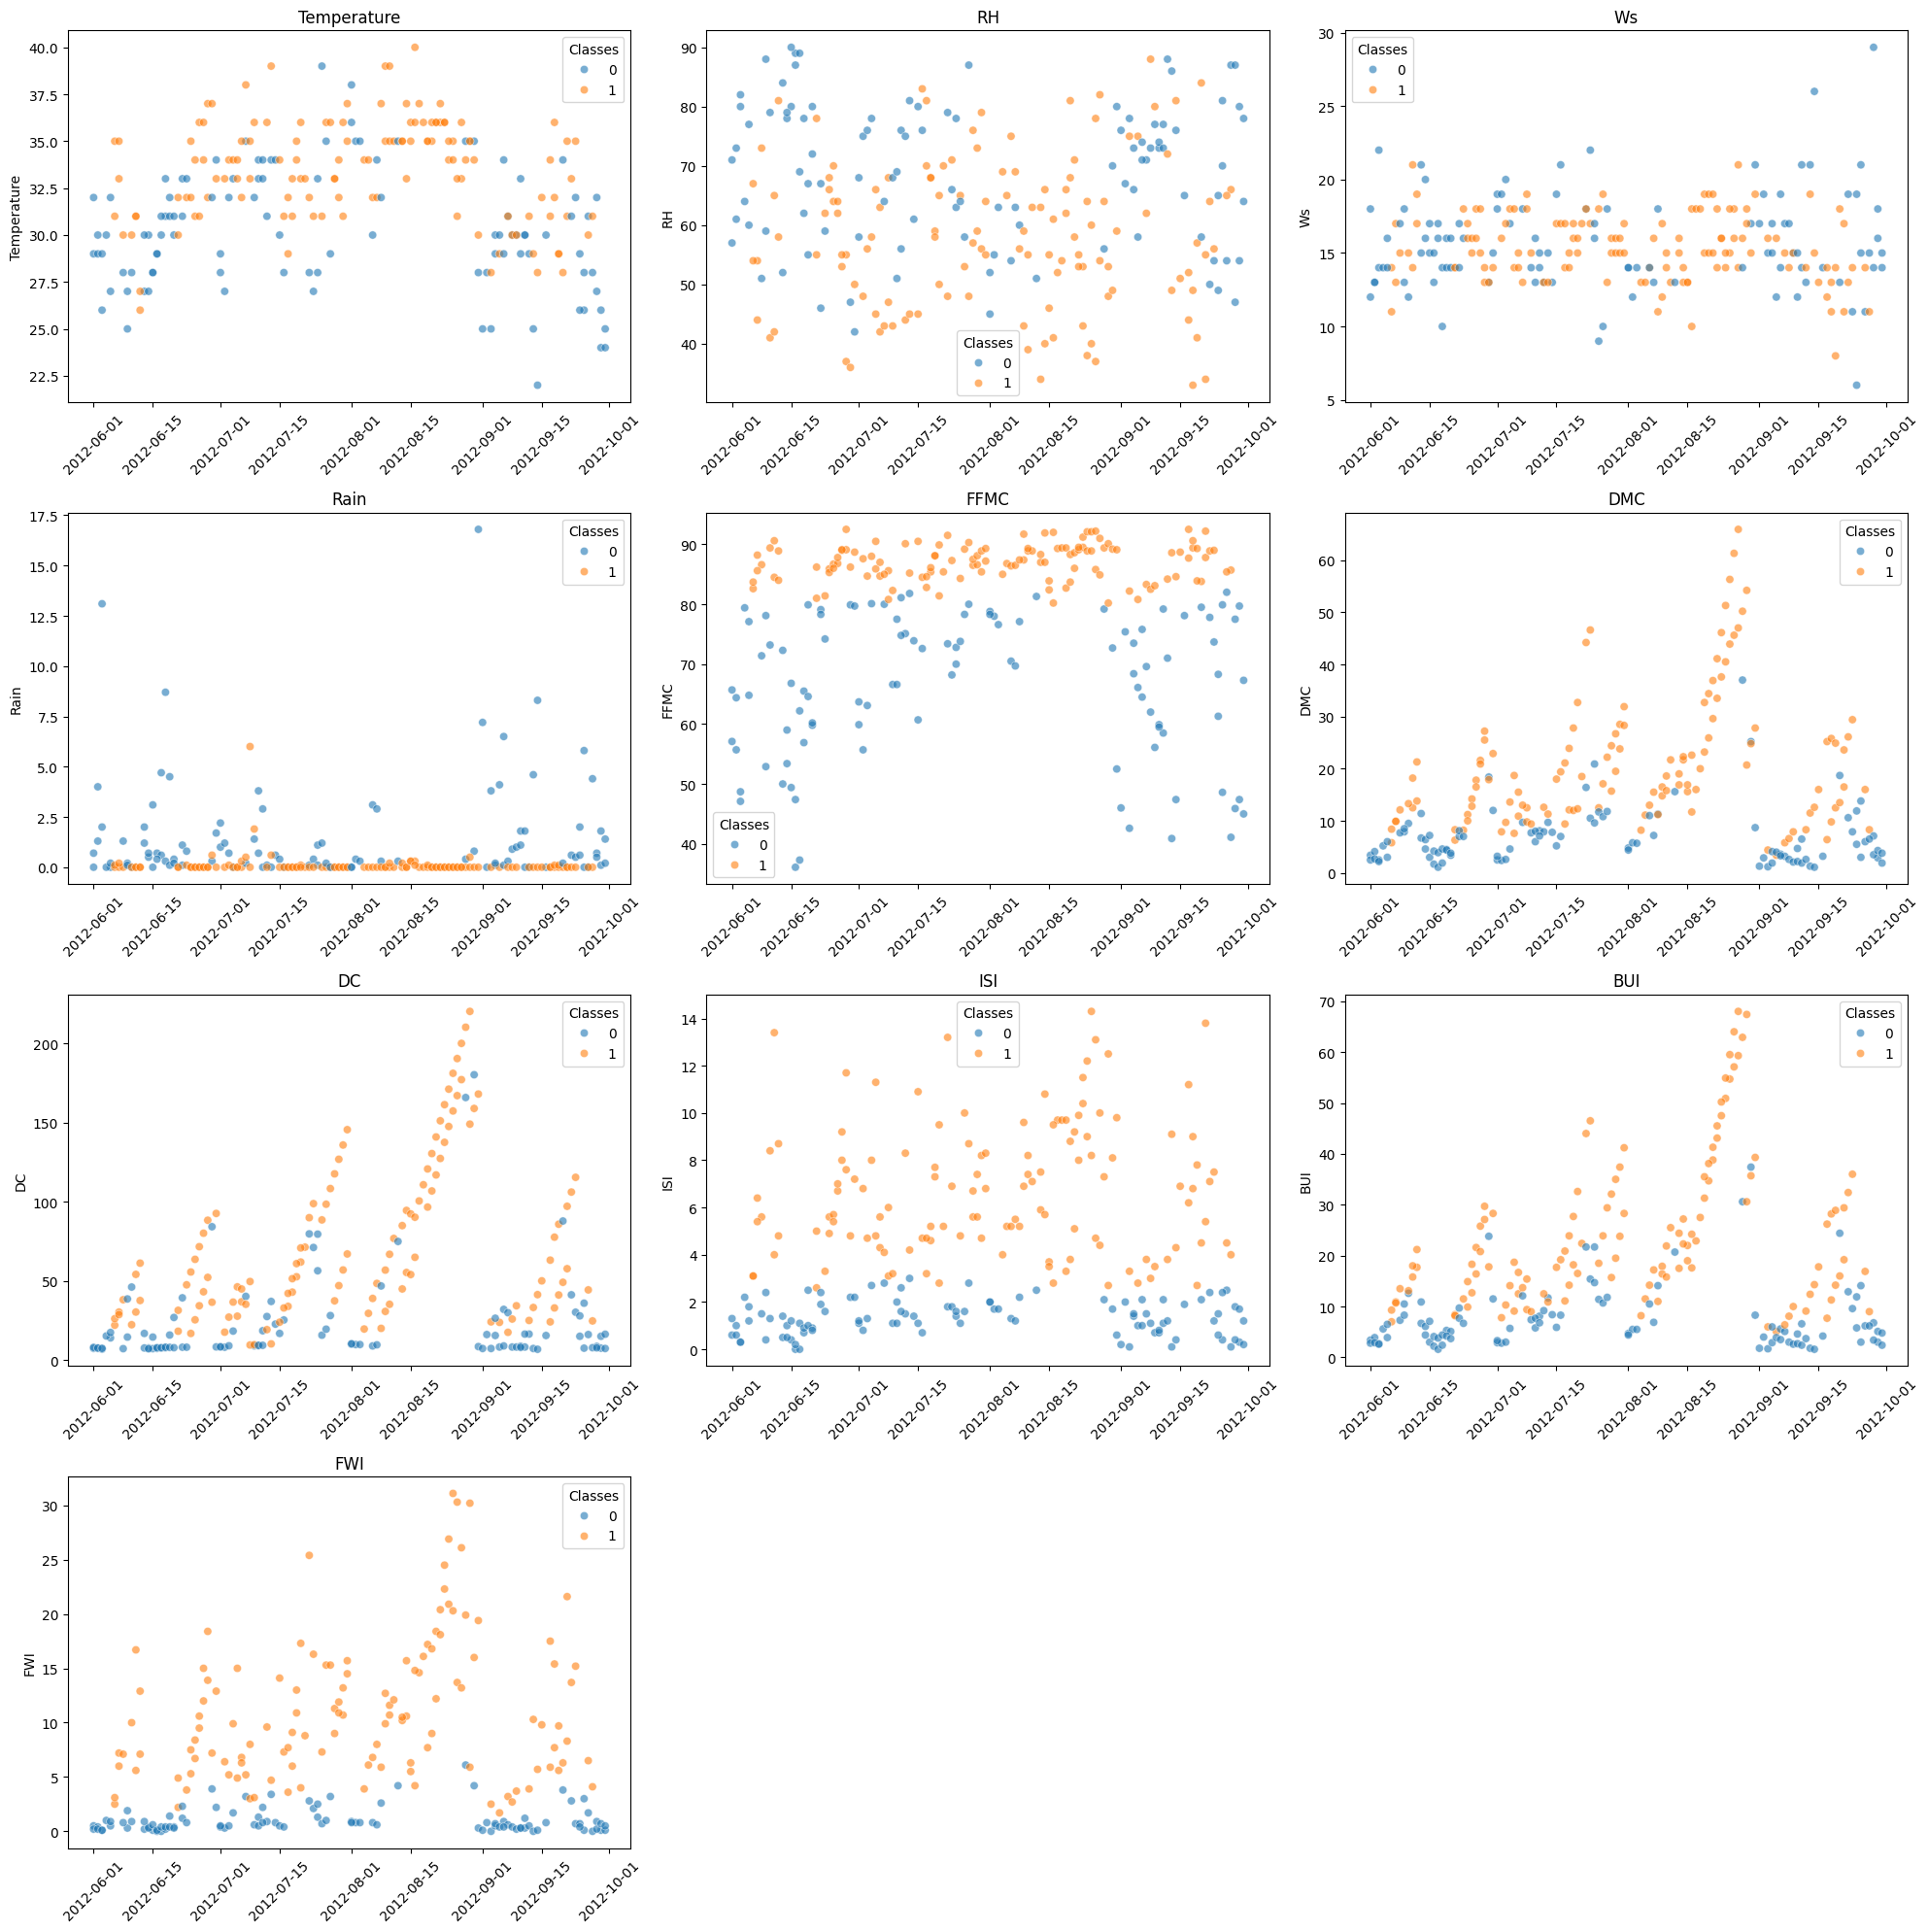

In [10]:
# Scatter plots
num_plots = len(numerical_cols)
n_rows = int(np.ceil(np.sqrt(num_plots)))
n_cols = int(np.ceil(num_plots / n_rows))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.scatterplot(data=df_filtered, x='date', y=col, hue='Classes', ax=axes[i], alpha=0.6)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots
for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

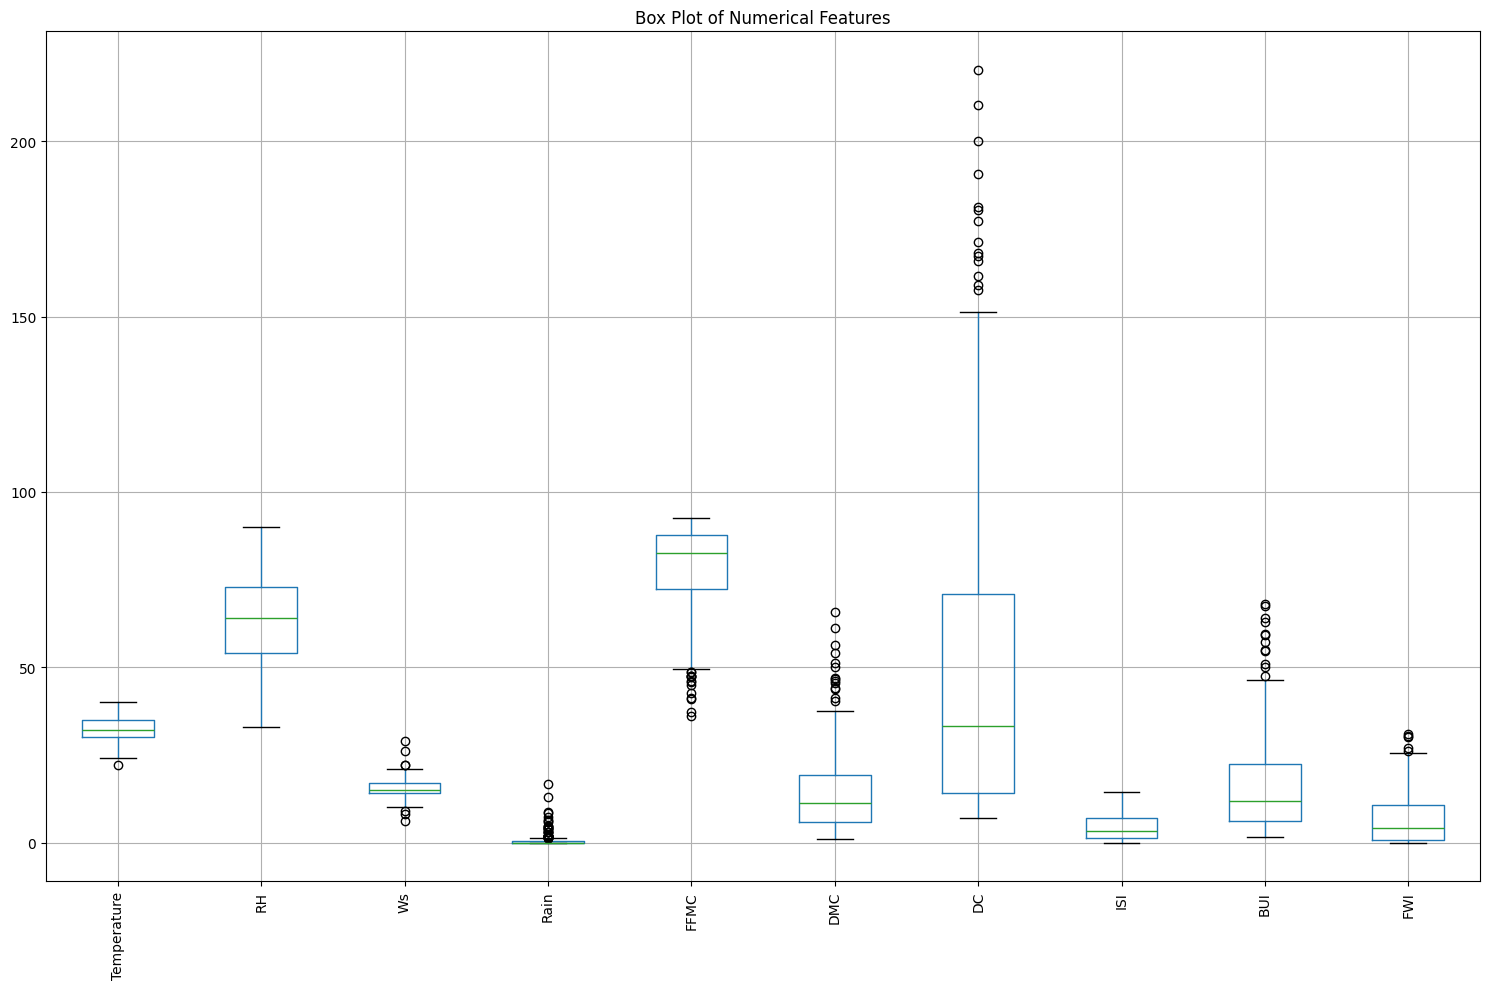

In [11]:
# Box plots
plt.figure(figsize=(15, 10))
df_filtered.drop(['date', 'Classes', 'Region','day','month','year'], axis=1).boxplot(rot=90)
plt.title('Box Plot of Numerical Features')
plt.tight_layout()
plt.show()



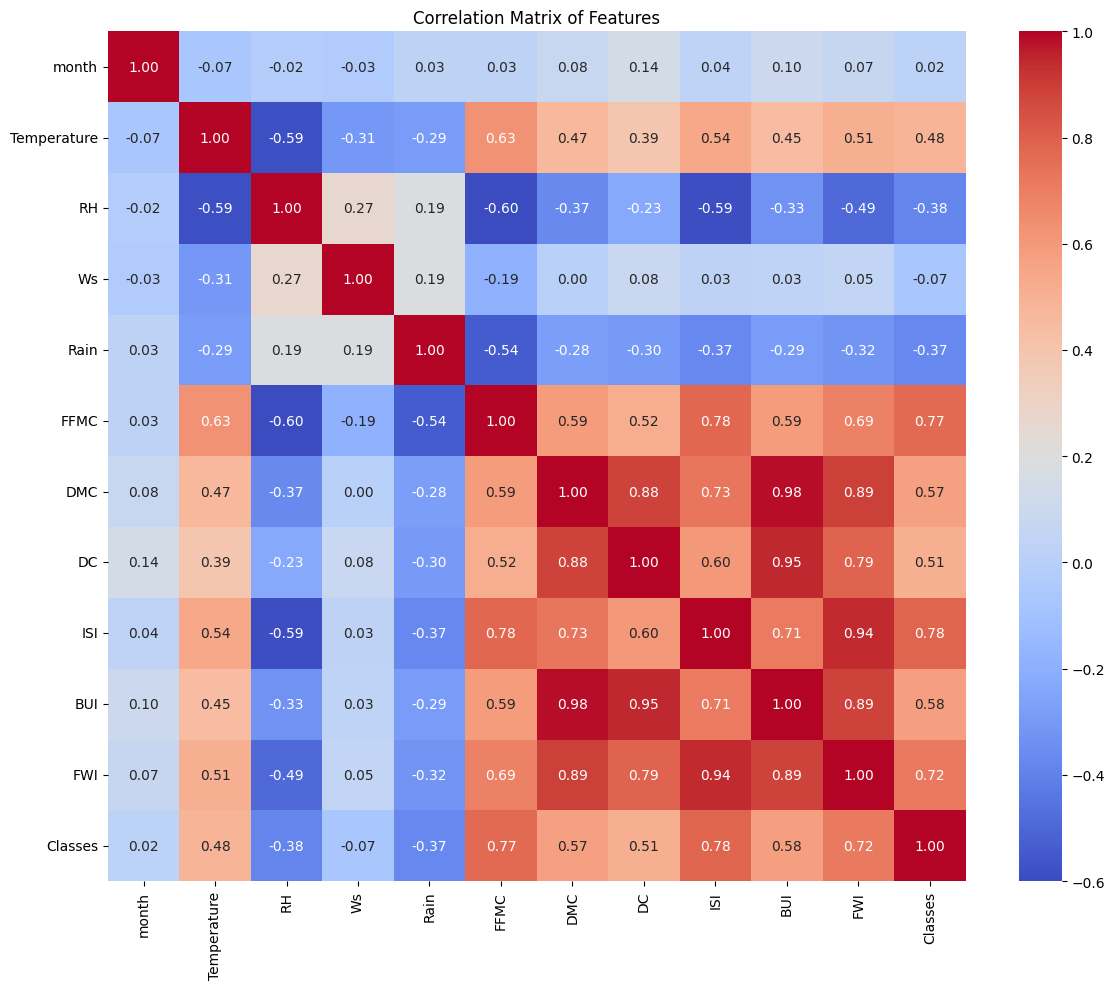

In [12]:
# Correlation matrix
correlation_matrix = df_filtered.drop(['date', 'Region','day','year'], axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

In [13]:
# Class distribution
print("\nClass Distribution:")
class_distribution = df_filtered['Classes'].value_counts(normalize=True)
print(class_distribution)
if abs(class_distribution[0] - class_distribution[1]) > 0.2:
  print("The classes are imbalanced. Consider using techniques to address this in modeling.")



Class Distribution:
Classes
1    0.554585
0    0.445415
Name: proportion, dtype: float64


In [14]:

print("\nTemporal Patterns:")
monthly_fire_rate = df_filtered.groupby(df_filtered['date'].dt.month)['Classes'].mean()
print("Monthly fire rates:")
print(monthly_fire_rate)



Temporal Patterns:
Monthly fire rates:
date
6    0.423729
7    0.616667
8    0.796296
9    0.392857
Name: Classes, dtype: float64


In [15]:
# Correlation Analysis
print("\nCorrelation Analysis:")
correlation_matrix = df_filtered.drop(['date', 'Region'], axis=1).corr()
high_correlations = correlation_matrix.where(np.abs(correlation_matrix) > 0.7).stack().reset_index()
high_correlations.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlations = high_correlations[high_correlations['Feature 1'] != high_correlations['Feature 2']]
print(high_correlations)



Correlation Analysis:
   Feature 1 Feature 2  Correlation
7       FFMC       ISI     0.779538
8       FFMC   Classes     0.773958
10       DMC        DC     0.883225
11       DMC       ISI     0.725763
12       DMC       BUI     0.982744
13       DMC       FWI     0.891995
14        DC       DMC     0.883225
16        DC       BUI     0.945633
17        DC       FWI     0.790546
18       ISI      FFMC     0.779538
19       ISI       DMC     0.725763
21       ISI       BUI     0.709908
22       ISI       FWI     0.941693
23       ISI   Classes     0.781589
24       BUI       DMC     0.982744
25       BUI        DC     0.945633
26       BUI       ISI     0.709908
28       BUI       FWI     0.886847
29       FWI       DMC     0.891995
30       FWI        DC     0.790546
31       FWI       ISI     0.941693
32       FWI       BUI     0.886847
34       FWI   Classes     0.717836
35   Classes      FFMC     0.773958
36   Classes       ISI     0.781589
37   Classes       FWI     0.717836


In [16]:
# Correlation Analysis
print("\nCorrelation Analysis:")
correlation_matrix = df_filtered.drop(['date', 'Region'], axis=1).corr()
strong_correlations = correlation_matrix.where(np.abs(correlation_matrix) > 0.9).stack().reset_index()
strong_correlations.columns = ['Feature 1', 'Feature 2', 'Correlation']
strong_correlations = strong_correlations[strong_correlations['Feature 1'] != strong_correlations['Feature 2']]
print(strong_correlations)


Correlation Analysis:
   Feature 1 Feature 2  Correlation
8        DMC       BUI     0.982744
10        DC       BUI     0.945633
12       ISI       FWI     0.941693
13       BUI       DMC     0.982744
14       BUI        DC     0.945633
16       FWI       ISI     0.941693


In [17]:
# Unique columns to drop
drop_columns = set(list(strong_correlations['Feature 1']) + list(strong_correlations['Feature 2']))
print("\nUnique columns to drop:")
print(drop_columns)

# Drop columns
df_filtered_dropped = df_filtered.drop(drop_columns, axis=1)

# Recalculate correlation
new_correlation_matrix = df_filtered_dropped.corr()
print("\nNew Correlation Matrix:")
print(new_correlation_matrix)



Unique columns to drop:
{'DC', 'FWI', 'BUI', 'ISI', 'DMC'}

New Correlation Matrix:
                  day     month  year  Temperature        RH        Ws  \
day          1.000000  0.025603   NaN     0.117898 -0.103778  0.046733   
month        0.025603  1.000000   NaN    -0.070303 -0.018162 -0.034418   
year              NaN       NaN   NaN          NaN       NaN       NaN   
Temperature  0.117898 -0.070303   NaN     1.000000 -0.585360 -0.307696   
RH          -0.103778 -0.018162   NaN    -0.585360  1.000000  0.265809   
Ws           0.046733 -0.034418   NaN    -0.307696  0.265809  1.000000   
Rain        -0.096248  0.025104   NaN    -0.288979  0.190510  0.187408   
FFMC         0.216654  0.027991   NaN     0.631210 -0.600089 -0.192328   
Classes      0.214676  0.020871   NaN     0.483755 -0.381934 -0.070254   
Region       0.021086 -0.018717   NaN     0.205538 -0.354718 -0.186917   
date         0.270610  0.969270   NaN    -0.041796 -0.042169 -0.022375   

                 Rain     

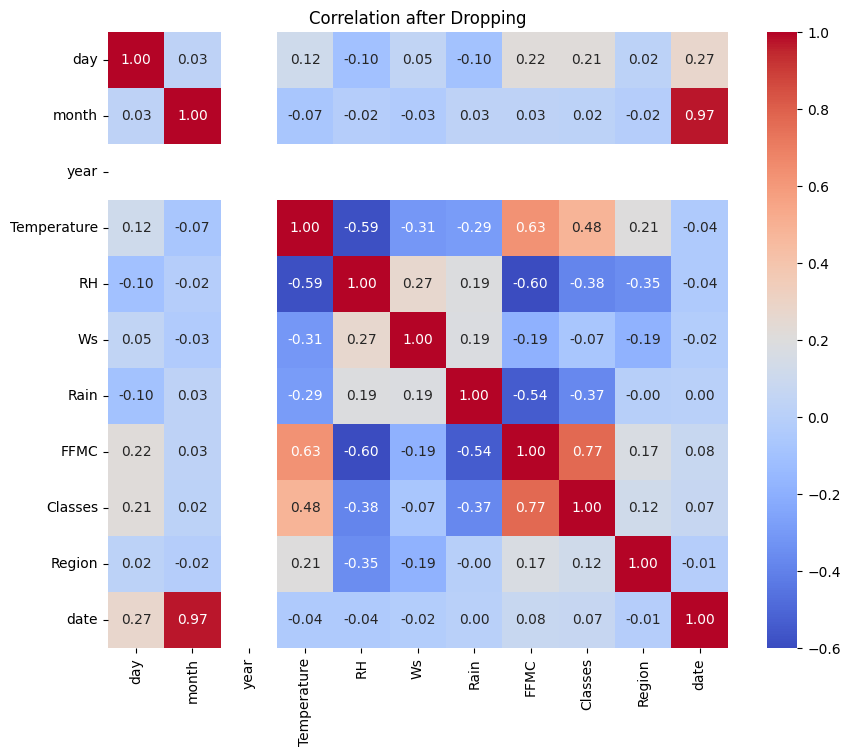

In [18]:
# Heatmap of new correlation after dropping

plt.figure(figsize=(10, 8))
sns.heatmap(new_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation after Dropping')
plt.show()

In [19]:

# Strong Correlation Pairs (>0.9) after dropping
new_strong_correlations = new_correlation_matrix.where(np.abs(new_correlation_matrix) > 0.9).stack().reset_index()
new_strong_correlations.columns = ['Feature 1', 'Feature 2', 'Correlation']
new_strong_correlations = new_strong_correlations[new_strong_correlations['Feature 1'] != new_strong_correlations['Feature 2']]
print("\nStrong Correlation Pairs (>0.9) after dropping:")
print(new_strong_correlations)


Strong Correlation Pairs (>0.9) after dropping:
   Feature 1 Feature 2  Correlation
2      month      date      0.96927
10      date     month      0.96927


In [20]:
print(df_filtered_dropped.head())

   day  month  year  Temperature  RH  Ws  Rain  FFMC  Classes  Region  \
0    1      6  2012           29  57  18   0.0  65.7        0       0   
1    2      6  2012           29  61  13   1.3  64.4        0       0   
2    3      6  2012           26  82  22  13.1  47.1        0       0   
4    5      6  2012           27  77  16   0.0  64.8        0       0   
5    6      6  2012           31  67  14   0.0  82.6        1       0   

        date  
0 2012-06-01  
1 2012-06-02  
2 2012-06-03  
4 2012-06-05  
5 2012-06-06  


In [21]:
def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for each feature.
    
    Parameters:
    X (pd.DataFrame): Input dataframe
    
    Returns:
    pd.DataFrame: VIF scores sorted in descending order
    """
    return pd.DataFrame({
        "Feature": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    }).sort_values("VIF", ascending=False)

In [22]:
def eliminate_high_vif_features(X, threshold=10):
    """
    Iteratively eliminate features with high VIF.
    
    Parameters:
    X (pd.DataFrame): Input dataframe
    threshold (int): VIF threshold (default=10)
    
    Returns:
    pd.DataFrame: Reduced dataframe with low VIF features
    """
    while True:
        vif_scores = calculate_vif(X)
        max_vif = vif_scores["VIF"].max()
        
        if max_vif > threshold:
            feature_to_drop = vif_scores.loc[vif_scores["VIF"] == max_vif, "Feature"].iloc[0]
            print(f"Dropped {feature_to_drop} with VIF {max_vif:.2f}")
            X = X.drop(feature_to_drop, axis=1)
            print("\nUpdated VIF scores:")
            print(calculate_vif(X))
        else:
            break
    
    return X  # Return only the DataFrame

In [23]:
# Drop unnecessary columns
df_1 = df_filtered.drop(['date', 'Classes'], axis=1)

# Print initial VIF scores
print("\nInitial VIF scores:")
print(calculate_vif(df_1))

# Eliminate high VIF features
X_reduced = eliminate_high_vif_features(df_1)

print("\nFinal VIF scores:")
print(calculate_vif(X_reduced))


Initial VIF scores:
        Feature         VIF
2          year  561.102135
11          BUI  184.360417
12          FWI  135.756817
8           DMC   80.413752
10          ISI   79.330650
9            DC   25.503457
7          FFMC    7.298883
4            RH    2.259576
3   Temperature    2.118577
13       Region    1.576661
6          Rain    1.546060
0           day    1.452641
5            Ws    1.404796
1         month    1.092265
Dropped year with VIF 561.10

Updated VIF scores:
        Feature         VIF
10          BUI  430.707371
11          FWI  247.728404
6          FFMC  216.565657
9           ISI  194.657470
7           DMC  191.670690
2   Temperature  113.373519
8            DC   52.165308
1         month   41.708308
3            RH   37.255041
4            Ws   35.168058
0           day    6.137530
12       Region    3.009615
5          Rain    1.730218
Dropped BUI with VIF 430.71

Updated VIF scores:
        Feature         VIF
10          FWI  216.816973
6          F

In [24]:
X_reduced

,day,RH,Rain,DC,ISI,Region
0,1,57,0.0,7.6,1.3,0
1,2,61,1.3,7.6,1.0,0
2,3,82,13.1,7.1,0.3,0
4,5,77,0.0,14.2,1.2,0
5,6,67,0.0,22.2,3.1,0
...,...,...,...,...,...,...
238,26,65,0.0,44.5,4.5,1
239,27,87,4.4,8.0,0.1,1
240,28,87,0.5,7.9,0.4,1
241,29,54,0.1,15.2,1.7,1


## Model Development and Analysis


Split Data


In [25]:
# Define features and target variable
X = X_reduced  # The reduced set of features after eliminating high VIF features
y = df_filtered['Classes']  # Target variable

# Split into training and testing datasets
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42, stratify=y
)

Feature Scaling & Defining Model


In [26]:
# Feature scaling (important for some algorithms like logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

In [27]:
# Base Logistic Regression Model
base_logistic_model = LogisticRegression(max_iter=10000)  
base_logistic_model.fit(X_train, y_train)
y_pred_base_logistic = base_logistic_model.predict(X_test)

# Polynomial Features
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Polynomial Logistic Regression Model
poly_logistic_model = LogisticRegression(max_iter=10000)  
poly_logistic_model.fit(X_train_poly, y_train)
y_pred_poly_logistic = poly_logistic_model.predict(X_test_poly)

Hyperparameter Tuning Space


In [28]:
# Hyperparameter Tuning Space
param_grid_logistic_l2 = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs', 'sag', 'saga'], 'max_iter': [10000]}
param_grid_logistic_l1 = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'max_iter': [10000]}
param_grid_logistic_elasticnet = {'C': [0.01, 0.1, 1, 10], 'penalty': ['elasticnet'], 'l1_ratio': [0.2, 0.5, 0.8], 'solver': ['saga'], 'max_iter': [10000]}

Perform GridSearchCV for Hyperparameter Tuning


In [29]:
# Perform GridSearchCV for Hyperparameter Tuning
logistic_l2_grid = GridSearchCV(LogisticRegression(), param_grid_logistic_l2, cv=5, scoring='accuracy')
logistic_l2_grid.fit(X_train, y_train)
y_pred_logistic_l2 = logistic_l2_grid.predict(X_test)

# Logistic Regression with L1 regularization
logistic_l1_grid = GridSearchCV(LogisticRegression(), param_grid_logistic_l1, cv=5, scoring='accuracy')
logistic_l1_grid.fit(X_train, y_train)
y_pred_logistic_l1 = logistic_l1_grid.predict(X_test)

# Logistic Regression with ElasticNet regularization
logistic_elasticnet_grid = GridSearchCV(LogisticRegression(), param_grid_logistic_elasticnet, cv=5, scoring='accuracy')
logistic_elasticnet_grid.fit(X_train, y_train)
y_pred_logistic_elasticnet = logistic_elasticnet_grid.predict(X_test)

# Polynomial Logistic Regression with L2 regularization
poly_logistic_l2_grid = GridSearchCV(LogisticRegression(), param_grid_logistic_l2, cv=5, scoring='accuracy')
poly_logistic_l2_grid.fit(X_train_poly, y_train)
y_pred_poly_logistic_l2 = poly_logistic_l2_grid.predict(X_test_poly)

# Polynomial Logistic Regression with L1 regularization
poly_logistic_l1_grid = GridSearchCV(LogisticRegression(), param_grid_logistic_l1, cv=5, scoring='accuracy')
poly_logistic_l1_grid.fit(X_train_poly, y_train)
y_pred_poly_logistic_l1 = poly_logistic_l1_grid.predict(X_test_poly)

# Polynomial Logistic Regression with ElasticNet regularization
poly_logistic_elasticnet_grid = GridSearchCV(LogisticRegression(), param_grid_logistic_elasticnet, cv=5, scoring='accuracy')
poly_logistic_elasticnet_grid.fit(X_train_poly, y_train)
y_pred_poly_logistic_elasticnet = poly_logistic_elasticnet_grid.predict(X_test_poly)

## Perform Cross-Validation

In [30]:
# Logistic Regression

scores_logistic_l2 = cross_val_score(LogisticRegression(**logistic_l2_grid.best_params_), X_train, y_train, cv=5, scoring='accuracy')

scores_logistic_l1 = cross_val_score(LogisticRegression(**logistic_l1_grid.best_params_), X_train, y_train, cv=5, scoring='accuracy')

scores_logistic_elasticnet = cross_val_score(LogisticRegression(**logistic_elasticnet_grid.best_params_), X_train, y_train, cv=5, scoring='accuracy')

# Polynomial Logistic Regression

scores_poly_logistic_l2 = cross_val_score(LogisticRegression(**poly_logistic_l2_grid.best_params_), X_train_poly, y_train, cv=5, scoring='accuracy')

scores_poly_logistic_l1 = cross_val_score(LogisticRegression(**poly_logistic_l1_grid.best_params_), X_train_poly, y_train, cv=5, scoring='accuracy')

scores_poly_logistic_elasticnet = cross_val_score(LogisticRegression(**poly_logistic_elasticnet_grid.best_params_), X_train_poly, y_train, cv=5, scoring='accuracy')

## Model Evaluation

In [31]:
# Model Evaluation
models = {
    'Base Logistic Regression': y_pred_base_logistic,
    'Polynomial Logistic Regression': y_pred_poly_logistic,
    'Logistic Regression L2': y_pred_logistic_l2,
    'Logistic Regression L1': y_pred_logistic_l1,
    'Logistic Regression ElasticNet': y_pred_logistic_elasticnet,
    'Polynomial Logistic Regression L2': y_pred_poly_logistic_l2,
    'Polynomial Logistic Regression L1': y_pred_poly_logistic_l1,
    'Polynomial Logistic Regression ElasticNet': y_pred_poly_logistic_elasticnet
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
results = []

for model_name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred)
    results.append([model_name, accuracy, precision, recall, f1, roc_auc])

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

In [32]:
# Print Cross-Validation Scores
print("Cross-Validation Scores:")
print("Logistic Regression L2:", scores_logistic_l2)
print("Logistic Regression L1:", scores_logistic_l1)
print("Logistic Regression ElasticNet:", scores_logistic_elasticnet)
print("Polynomial Logistic Regression L2:", scores_poly_logistic_l2)
print("Polynomial Logistic Regression L1:", scores_poly_logistic_l1)
print("Polynomial Logistic Regression ElasticNet:", scores_poly_logistic_elasticnet)

Cross-Validation Scores:
Logistic Regression L2: [0.94594595 0.94594595 0.97297297 1.         0.97222222]
Logistic Regression L1: [0.97297297 0.97297297 0.97297297 1.         0.97222222]
Logistic Regression ElasticNet: [0.97297297 0.97297297 0.97297297 1.         0.97222222]
Polynomial Logistic Regression L2: [0.89189189 0.86486486 0.94594595 1.         0.97222222]
Polynomial Logistic Regression L1: [0.97297297 0.91891892 0.97297297 1.         0.97222222]
Polynomial Logistic Regression ElasticNet: [0.91891892 0.97297297 0.94594595 0.97222222 0.97222222]


In [33]:
# Display results
print("\nModel Performance:")
print(results_df)


Model Performance:
                                       Model  Accuracy  Precision    Recall  \
0                   Base Logistic Regression  1.000000   1.000000  1.000000   
1             Polynomial Logistic Regression  1.000000   1.000000  1.000000   
2                     Logistic Regression L2  0.978261   0.962963  1.000000   
3                     Logistic Regression L1  0.978261   0.962963  1.000000   
4             Logistic Regression ElasticNet  0.978261   0.962963  1.000000   
5          Polynomial Logistic Regression L2  1.000000   1.000000  1.000000   
6          Polynomial Logistic Regression L1  1.000000   1.000000  1.000000   
7  Polynomial Logistic Regression ElasticNet  0.978261   1.000000  0.961538   

   F1 Score   ROC AUC  
0  1.000000  1.000000  
1  1.000000  1.000000  
2  0.981132  0.975000  
3  0.981132  0.975000  
4  0.981132  0.975000  
5  1.000000  1.000000  
6  1.000000  1.000000  
7  0.980392  0.980769  


## Save the best models

In [34]:

# Save the best models
# 'Polynomial Logistic Regression L1' is the best polynomial logistic regression model based on evaluation
# 'Logistic Regression L1' is the best logistic regression based model on evaluation
best_poly_logistic_model_name = 'Polynomial Logistic Regression L1'  
best_base_logistic_model_name = 'Logistic Regression L1'  

    
# Save best models
poly_logistic_filename = f'{best_poly_logistic_model_name}_model.pkl'
base_logistic_filename = f'{best_base_logistic_model_name}_model.pkl'

pickle.dump(poly_logistic_l1_grid.best_estimator_, open(poly_logistic_filename, 'wb'))
pickle.dump(logistic_l1_grid.best_estimator_, open(base_logistic_filename, 'wb'))

# Load saved models
best_poly_logistic_model = pickle.load(open(poly_logistic_filename, 'rb'))
best_base_logistic_model = pickle.load(open(base_logistic_filename, 'rb'))

# Make predictions on test data
poly_logistic_y_pred = best_poly_logistic_model.predict(X_test_poly)
base_logistic_y_pred = best_base_logistic_model.predict(X_test)

# Calculate metrics
poly_logistic_metrics = {
    'Accuracy': accuracy_score(y_test, poly_logistic_y_pred),
    'Precision': precision_score(y_test, poly_logistic_y_pred, zero_division=0),
    'Recall': recall_score(y_test, poly_logistic_y_pred, zero_division=0),
    'F1 Score': f1_score(y_test, poly_logistic_y_pred, zero_division=0),
    'ROC AUC': roc_auc_score(y_test, poly_logistic_y_pred)
}

base_logistic_metrics = {
    'Accuracy': accuracy_score(y_test, base_logistic_y_pred),
    'Precision': precision_score(y_test, base_logistic_y_pred, zero_division=0),
    'Recall': recall_score(y_test, base_logistic_y_pred, zero_division=0),
    'F1 Score': f1_score(y_test, base_logistic_y_pred, zero_division=0),
    'ROC AUC': roc_auc_score(y_test, base_logistic_y_pred)
}

# Display metrics
print(f"\n Metrices for Best {best_poly_logistic_model_name} saved model:")
for metric_name, metric_value in poly_logistic_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

print(f"\n Metrices for Best {best_base_logistic_model_name} saved model:")
for metric_name, metric_value in base_logistic_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")
                            


 Metrices for Best Polynomial Logistic Regression L1 saved model:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

 Metrices for Best Logistic Regression L1 saved model:
Accuracy: 0.9783
Precision: 0.9630
Recall: 1.0000
F1 Score: 0.9811
ROC AUC: 0.9750


### Comprehensive Analysis of the Results

#### Cross-Validation Scores:
The cross-validation scores indicate model performance consistency on unseen data during training. Higher scores denote better generalizability.

- **Polynomial Logistic Regression (L2, L1, and ElasticNet)** show slightly lower but stable cross-validation scores than regular logistic regression models.
- **Logistic Regression (L2, L1, and ElasticNet)** models yield consistently high cross-validation scores across all folds, indicating strong model robustness.

#### Model Performance Analysis (Accuracy, Precision, Recall, F1 Score, and ROC AUC):
These metrics collectively reveal each model's capability to classify the target variable accurately.

- **Accuracy**: Most models demonstrate very high accuracy (between 0.978 and 1.000), with both base logistic regression and polynomial logistic regression models achieving perfect accuracy.
- **Precision, Recall, and F1 Score**: Polynomial logistic regression models yield perfect scores for precision, recall, and F1, reflecting excellent performance in identifying each class correctly.
- **ROC AUC**: Most models achieve a high ROC AUC score, with both base logistic regression and polynomial logistic regression models achieving a perfect score of 1.000, indicating their strong classification ability.

#### Model Comparison and Performance Insights:
- **Best Models**: Polynomial logistic regression (L2 and L1) models, along with the base logistic regression, demonstrate the highest accuracy, precision, recall, F1, and ROC AUC scores. 
- **Strong Contenders**: Standard logistic regression (L2, L1, ElasticNet) also exhibit high performance across all metrics, though slightly lower than polynomial versions.
  
#### Conclusion:
The polynomial logistic regression models, particularly with L2 and L1 regularization, deliver the most consistent performance across cross-validation and evaluation metrics. These models provide the highest precision and recall, indicating they can classify the target variable with high accuracy and minimal misclassification. Given the observed performance, polynomial logistic regression models with L2 and L1 regularization are recommended for this classification problem, demonstrating that introducing polynomial features significantly enhances predictive performance.